## Project Scope
- Analyse the given data about endangered animal;
- Create visual plots to connect the information within the data sets;
- Answer some questions on the data to look for insights, such as:
    - What is the distribution of conservation_status for animals?
    - Are certain types of species more likely to be endangered?
    - Are the differences between species and their conservation status significant?
    - Which species were spotted the most at each park?
- Create a slide presentation with project analysis and conclusions.

### Import Libs

In [676]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

### Function Definitions

In [436]:
def plot_bar_percentages(g, include_values=False, label_type='edge', padding=3, **kwargs):
    if len(g.containers) > 1:
        total = sum([container.datavalues for container in g.containers])
        for i in range(len(g.containers)):
            labels = [f'{j * 100 :.1f}%' for j in g.containers[i].datavalues / total]
            if include_values:
                values = g.containers[i].datavalues
                labels = [f'{int(value)} ({label})' for value, label in zip(values, labels)]
            g.bar_label(g.containers[i], labels=labels, label_type=label_type, padding=padding, **kwargs)
    else:
        labels = [f'{i * 100 :.1f}%' for i in g.containers[0].datavalues / sum(g.containers[0].datavalues)]
        if include_values:
            values = g.containers[0].datavalues
            labels = [f'{int(value)} ({label})' for value, label in zip(values, labels)]
        g.bar_label(g.containers[0], labels=labels, label_type=label_type, padding=padding, **kwargs)

def pct_label(pct):
    '''
    Add decimal value if pct not int
    '''
    if round(pct, 1) != int(pct):
        return f"{pct:.1f}%"
    return f"{int(pct)}%"

def pct_adjust(autopcts, color = 'white', threshold = 5, distance = 1.4):
    '''
    Adjust percentage label color and position
    '''
    for pct in autopcts:
            # Set pct color to white
            pct.set_color(color)

            # Modify label positions for percentages < 5%
            if float(pct.get_text().strip('%')) < threshold:
                pos = pct.get_position()
                pct.set_position(tuple(map(lambda x: x * distance, pos)))

### Load Data

In [437]:
info = pd.read_csv('../Data/Raw/species_info.csv')
obs = pd.read_csv('../Data/Raw/observations.csv')

print('*' * 50, 'SPECIES INFO DATA SET', '*' * 50)
display(info.head())
print(info.shape)
print('*' * 50, 'OBSERVATIONS DATA SET', '*' * 50)
display(obs.head())
print(obs.shape)

************************************************** SPECIES INFO DATA SET **************************************************


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


(5824, 4)
************************************************** OBSERVATIONS DATA SET **************************************************


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


(23296, 3)


In [438]:
# Rename missing values in conservation_status column
info.conservation_status.fillna('Unclassified', inplace=True)

# Add protected status
info['is_protected'] = info.conservation_status != 'Unclassified'

# Drop column common_names since it has no use for this analysis
info.drop(columns='common_names', inplace=True)

# Remove Duplicated rows to have a unique scientific_name per row
info.drop_duplicates(inplace=True)

In [439]:
# Check if all scientific names are unique
info.scientific_name.value_counts()

Oncorhynchus mykiss                2
Canis lupus                        2
Clethrionomys gapperi gapperi      1
Valeriana dioica var. sylvatica    1
Gaultheria humifusa                1
                                  ..
Viola pubescens                    1
Viola porterana                    1
Viola pedata                       1
Viola odorata                      1
Tribulus terrestris                1
Name: scientific_name, Length: 5541, dtype: int64

In [440]:
# Check scientific names that are not unique
display(info[info.scientific_name.isin(['Oncorhynchus mykiss', 'Canis lupus'])])

,category,scientific_name,conservation_status,is_protected
8,Mammal,Canis lupus,Endangered,True
560,Fish,Oncorhynchus mykiss,Unclassified,False
3020,Mammal,Canis lupus,In Recovery,True
3283,Fish,Oncorhynchus mykiss,Threatened,True


In [441]:
# Remove first appearance of each species, as it shows an evolution in their conservation_status
info = info.drop([8, 560]).reset_index(drop=True)
info

,category,scientific_name,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Unclassified,False
1,Mammal,Bos bison,Unclassified,False
2,Mammal,Bos taurus,Unclassified,False
3,Mammal,Ovis aries,Unclassified,False
4,Mammal,Cervus elaphus,Unclassified,False
...,...,...,...,...
5536,Vascular Plant,Solanum parishii,Unclassified,False
5537,Vascular Plant,Solanum xanti,Unclassified,False
5538,Vascular Plant,Parthenocissus vitacea,Unclassified,False
5539,Vascular Plant,Vitis californica,Unclassified,False


In [442]:
# Create DF with only classified species
classified = info[info.conservation_status != 'Unclassified']
classified

,category,scientific_name,conservation_status,is_protected
7,Mammal,Canis latrans,Species of Concern,True
8,Mammal,Canis rufus,Endangered,True
28,Mammal,Eptesicus fuscus,Species of Concern,True
29,Mammal,Lasionycteris noctivagans,Species of Concern,True
32,Mammal,Myotis austroriparius,Species of Concern,True
...,...,...,...,...
5049,Vascular Plant,Callitriche marginata,Species of Concern,True
5140,Vascular Plant,Camissonia sierrae ssp. alticola,Species of Concern,True
5166,Vascular Plant,Epilobium oreganum,Species of Concern,True
5175,Vascular Plant,Botrychium ascendens,Species of Concern,True


In [443]:
# Create merged df
merge = obs.merge(info, how='left', on='scientific_name')
merge

,scientific_name,park_name,observations,category,conservation_status,is_protected
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,Unclassified,False
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,Unclassified,False
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Unclassified,False
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Unclassified,False
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Unclassified,False
...,...,...,...,...,...,...
23291,Croton monanthogynus,Yosemite National Park,173,Vascular Plant,Unclassified,False
23292,Otospermophilus beecheyi,Bryce National Park,130,Mammal,Unclassified,False
23293,Heterotheca sessiliflora ssp. echioides,Bryce National Park,140,Vascular Plant,Unclassified,False
23294,Dicranella rufescens,Yosemite National Park,171,Nonvascular Plant,Unclassified,False


### First Analysis

In [444]:
print('Species Categories:', info.category.unique().tolist())
print('Different Species:', info.scientific_name.nunique())
print('Species Conservation Status:', info.conservation_status.unique().tolist())
print('Park Names:', obs.park_name.unique().tolist())

Species Categories: ['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant', 'Nonvascular Plant']
Different Species: 5541
Species Conservation Status: ['Unclassified', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Park Names: ['Great Smoky Mountains National Park', 'Yosemite National Park', 'Bryce National Park', 'Yellowstone National Park']


### Data Visualization

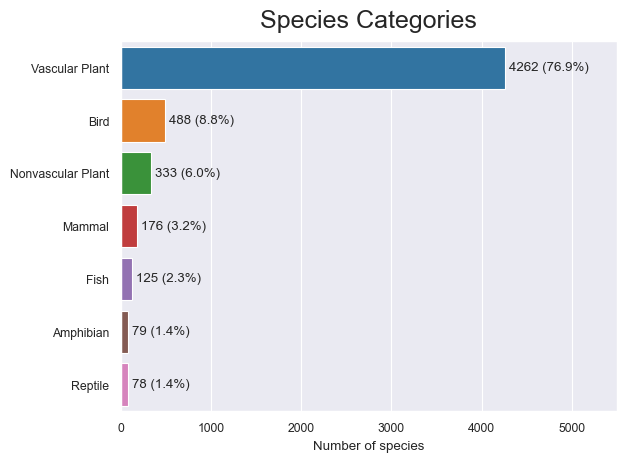

In [445]:
g = sns.countplot(data=info, y='category', order=info.category.value_counts().index)
plt.title('Species Categories', fontsize=18, pad=10)
plt.xlim(0, 5500)
plot_bar_percentages(g, include_values=True)
g.set(ylabel='', xlabel='Number of species');

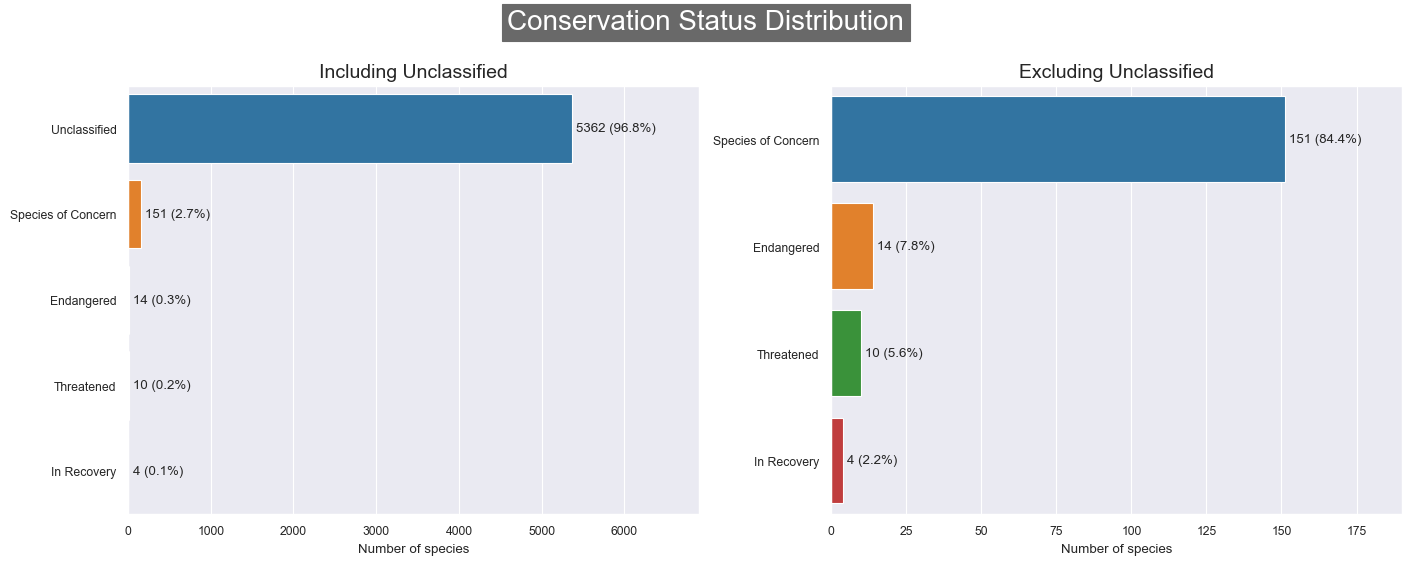

In [616]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')
fig.suptitle('Conservation Status Distribution', fontsize=20, y=1.1, backgroundcolor='dimgray', color='w')

g1 = sns.countplot(data=info, y='conservation_status', order=info.conservation_status.value_counts().index, ax=axs[0])
g1.set_title('Including Unclassified', fontsize=14)
g1.set_xlim(0, 6900)
plot_bar_percentages(g1, include_values=True)
g1.set(ylabel='', xlabel='Number of species')

g2 = sns.countplot(data=classified, y='conservation_status', order=classified.conservation_status.value_counts().index, ax=axs[1])
g2.set_title('Excluding Unclassified', fontsize=14)
g2.set_xlim(0, 190)
plot_bar_percentages(g2, include_values=True)
g2.set(ylabel='', xlabel='Number of species');

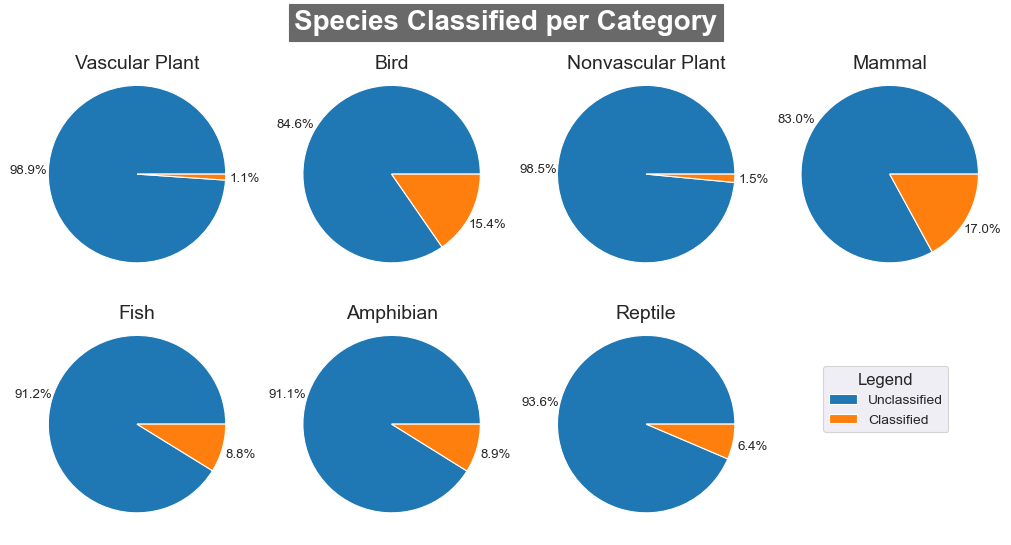

In [615]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), layout='constrained')
fig.suptitle('Species Classified per Category', fontsize=20, fontweight='bold', y=1.08, backgroundcolor='dimgray', color='w')

# Remove blank axes
fig.delaxes(axs[1, 3])

# Plot each category chart
for i, category in enumerate(info.category.value_counts().index, start=1):
    plt.subplot(2, 4, i)
    data = info[info.category == category]['is_protected'].value_counts()
    _, _, autopcts = plt.pie(data, autopct='%.1f%%', pctdistance=1.22)
    plt.title(f'{category}', fontsize=14, y=0.94)

# Create a legend in the last subplot
legend_labels = ['Unclassified', 'Classified']
fig.legend(title='Legend', labels=legend_labels, loc='center',
           bbox_to_anchor=(0.88, 0.3),
           title_fontsize=12,
           fontsize=10
        );

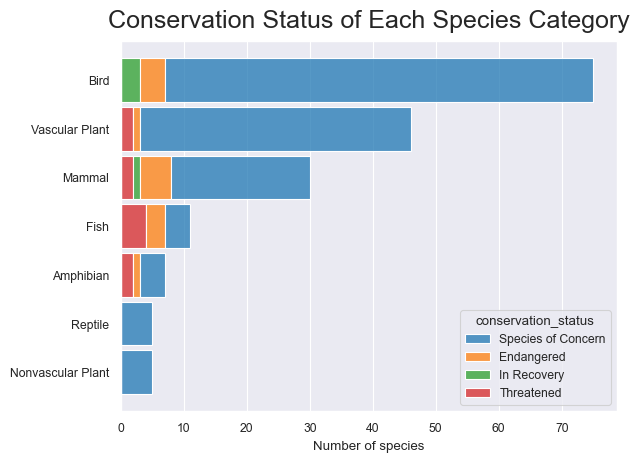

In [728]:
# Sort DF by category counts
category_counts = classified['category'].value_counts()
sorted_classified = classified.sort_values(by='category', key=lambda x: x.map(category_counts), ascending=False)

# Plot species categories by conservation status, excluding unclassified species
g = sns.histplot(data=sorted_classified, y='category', hue='conservation_status', multiple='stack', shrink=0.9)
g.grid(axis='y')
plt.title('Conservation Status of Each Species Category', fontsize=18, pad=10)
plt.ylabel('')
plt.xlabel('Number of species');

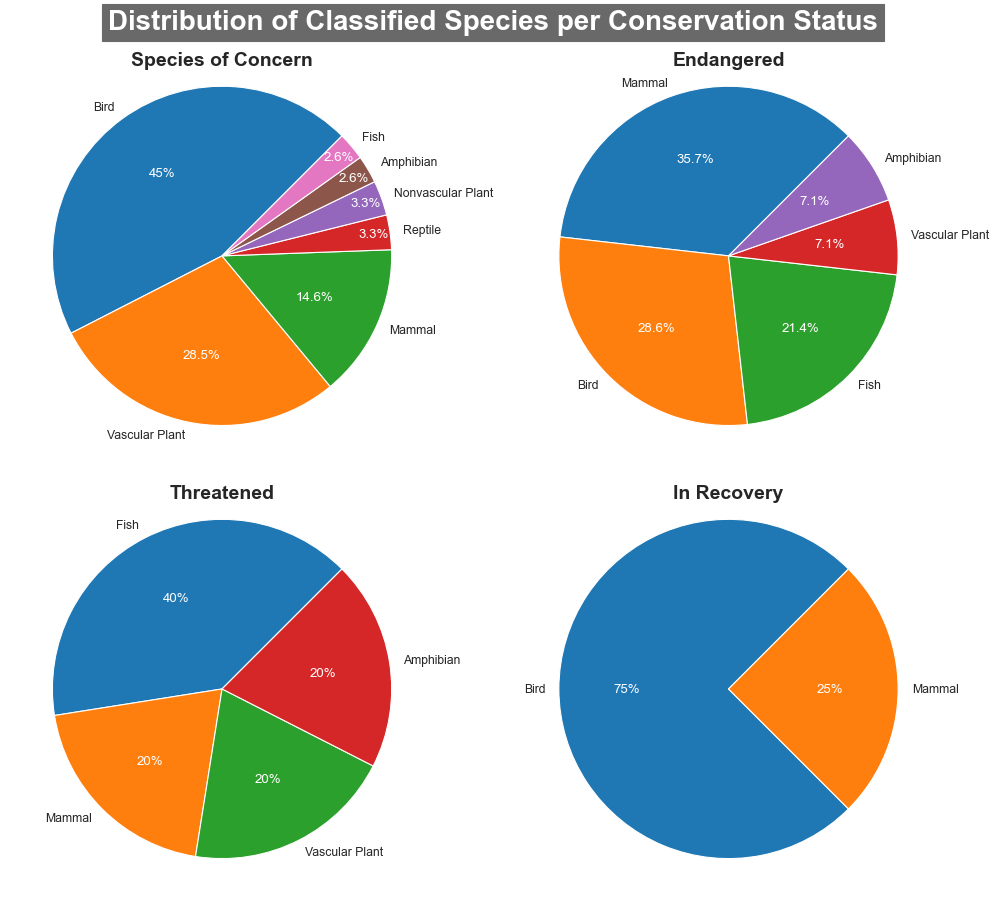

In [612]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9), layout='constrained')
fig.suptitle('Distribution of Classified Species per Conservation Status', fontsize=20, fontweight='bold', backgroundcolor='dimgray', color='w')

for i, status in enumerate(classified.conservation_status.unique(), start=1):
    plt.subplot(2, 2, i)
    
    # Plot pie chart for each conservation status
    data = classified[classified.conservation_status == status]['category'].value_counts()
    _, _, autopcts = plt.pie(data, labels=data.index, autopct=lambda pct: pct_label(pct), startangle=45, labeldistance=1.08)
    
    # Modify each pct label
    pct_adjust(autopcts, distance=1.5)
    
    # Set pie chart title
    plt.title(f'{status}', fontsize=14, y=0.93, weight='bold')

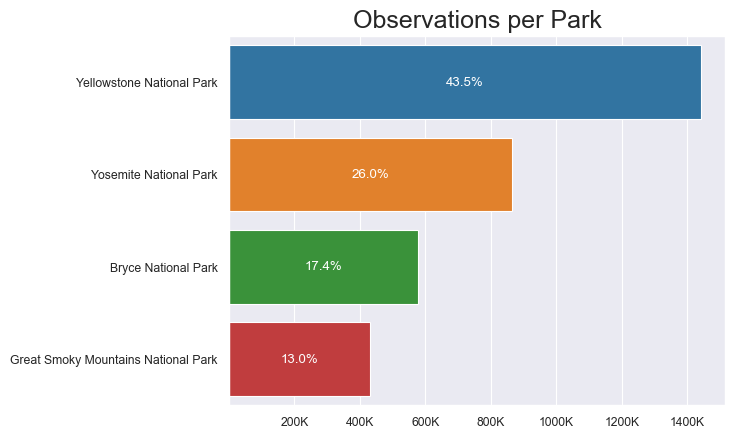

In [717]:
# Plot observations per park
observations_count = obs.groupby('park_name').observations.sum().sort_values(ascending=False)
g = sns.barplot(x=observations_count.values, y=observations_count.index)

# Adjust chart labels
g.set_xticks(range(0, 1500000, 200000))
g.set_xticklabels([f'{x/1000:.0f}K'  if x != 0 else '' for x in range(0, 1500000, 200000)])
plt.title('Observations per Park', fontsize=18)
plt.ylabel('')
plot_bar_percentages(g, label_type='center', padding=0, color='white');

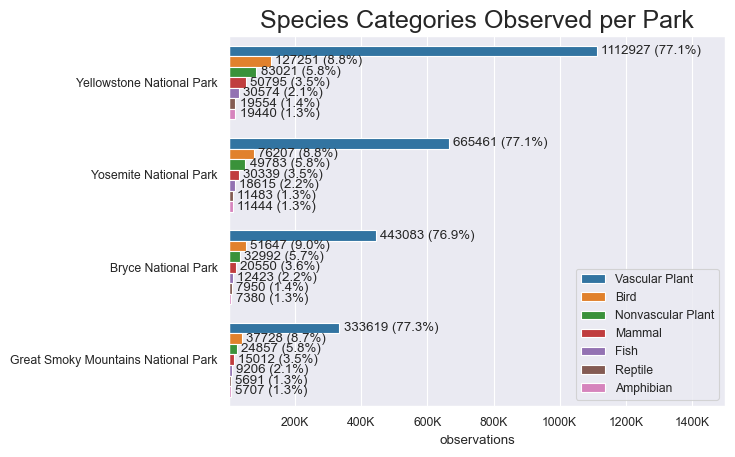

In [914]:
# Prepare DF to be plotted
park_category = merge.groupby(['park_name', 'category'])['observations'].sum().reset_index()
cat_count = park_category.groupby(['category'])['observations'].sum().sort_values(ascending=False)

# Sort DF by observations count
sorted_park_category = park_category.sort_values(by=['park_name', 'category'], key=lambda col: col.map(cat_count), ascending=False)

# Plot bar chart
g = sns.barplot(data=sorted_park_category, x='observations', y='park_name', hue='category', order=observations_count.index)

g.set_xticks(range(0, 1500000, 200000))
g.set_xticklabels([f'{x/1000:.0f}K'  if x != 0 else '' for x in range(0, 1500000, 200000)])
g.set_xlim(0, 1500000)
g.legend(loc='lower right')
plt.title('Species Categories Observed per Park', fontsize=18)
plt.ylabel('')
plot_bar_percentages(g, include_values=True);

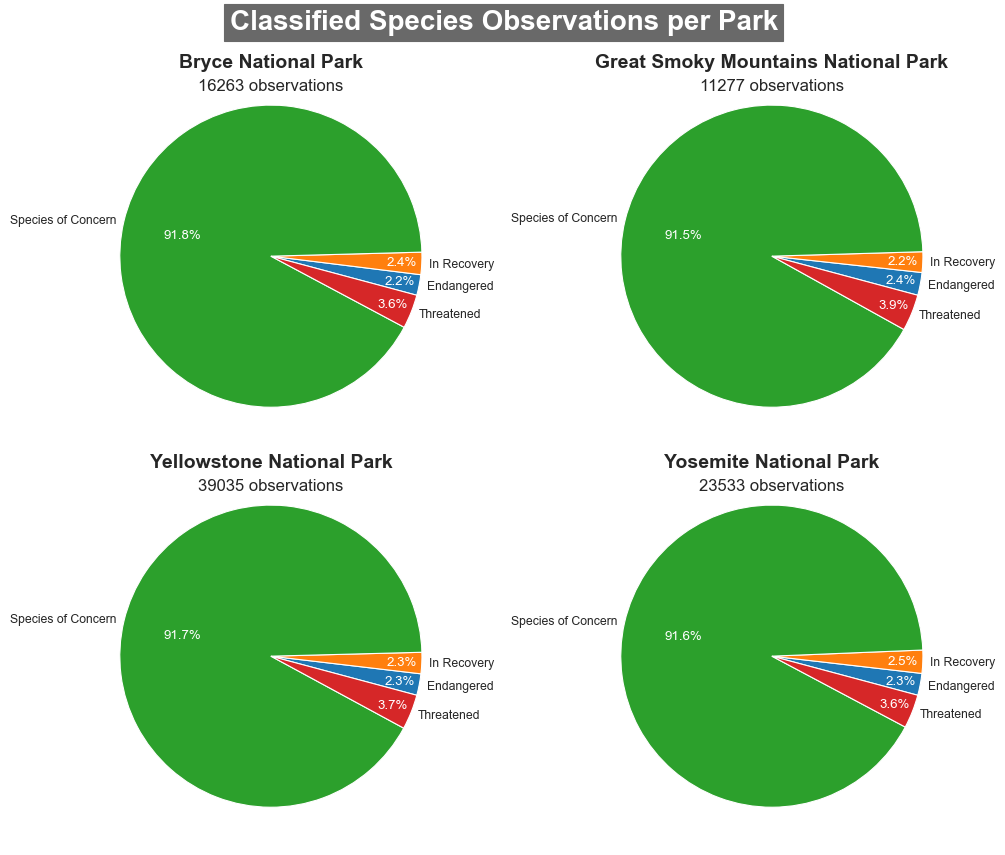

In [594]:
# Plot 1 pie chart for each park's classfied species observation
fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='constrained')
fig.suptitle('Classified Species Observations per Park', fontsize=20, fontweight='bold', y=1.05, backgroundcolor='dimgray', color='w')

# Prepare DF to be plotted
park_conservation = merge[merge.conservation_status != 'Unclassified']\
    .groupby(['park_name', 'conservation_status'])['observations'].sum()\
        .reset_index()

# Plot each chart
for i, park in enumerate(park_conservation.park_name.unique(), start=1):
    plt.subplot(2, 2, i)
    
    # Plot pie chart for each park
    data = park_conservation[park_conservation.park_name == park]
    _, _, autopcts = plt.pie(x='observations', data=data, labels='conservation_status', autopct=lambda pct: pct_label(pct), startangle=-15, labeldistance=1.05)
    
    # Modify each pct label
    pct_adjust(autopcts, distance=1.45)
    
    # Set pie chart title
    count = data.observations.sum()
    plt.text(0, 1.25, f'{park}',fontsize=14, fontweight='bold', ha='center')
    plt.text(0, 1.1,f'{count} observations', fontsize=12, ha='center')